In [25]:
import heapq
import scipy.stats as sts
import numpy as np
import matplotlib.pyplot as plt

class Event:
    def __init__(self, timestamp, function):
        self.timestamp = timestamp
        self.function = function

    def __lt__(self, other):
        return self.timestamp < other.timestamp

    def run(self, schedule):
        self.function(schedule)

class Schedule:
    def __init__(self):
        self.now = 0  # Keep track of the current simulation time
        self.priority_queue = []  # The priority queue of events to run
    
    def add_event_at(self, timestamp, function):
        # Add an event to the schedule at a particular point in time.
        heapq.heappush(
            self.priority_queue,
            Event(timestamp, function))
    
    def add_event_after(self, interval, function):
        # Add an event to the schedule after a specified time interval.
        self.add_event_at(self.now + interval, function)
    
    def next_event_time(self):
        # Return the time of the next event. The `now` attribute of this class
        # contain the time of the last event that was run.
        return self.priority_queue[0].timestamp

    def run_next_event(self):
        # Get the next event from the priority queue and run it.
        event = heapq.heappop(self.priority_queue)
        self.now = event.timestamp
        event.run(self)
        
    def __repr__(self):
        return (
            f'Schedule() at time {self.now} ' +
            f'with {len(self.priority_queue)} events in the queue')
    
    def print_events(self):
        # Print out diagnostic information about the events in the schedule.
        print(repr(self))
        for event in sorted(self.priority_queue):
            print(f'   {event.timestamp}: {event.function.__name__}')

class Queue:
    def __init__(self, service_rate):
        self.queue = 0
        self.served = 0
        self.service_rate = service_rate

    def serve(self, schedule):
        if self.queue > 0:
            self.queue -= 1
            self.served += 1     
        schedule.add_event_after(1/self.service_rate, self.serve)  

    def arrive(self):
        self.queue += 1

class BusSystem:
    def __init__(self, Queue, arrival_rate):
        self.Queue = Queue        
        self.arrival_distribution = sts.expon(scale=1/arrival_rate)

    def addToQueue(self, schedule):
        self.Queue.arrive()
        schedule.add_event_after(self.arrival_distribution.rvs(), self.addToQueue)

    def run(self,schedule):
        start_time = self.arrival_distribution.rvs()
        schedule.add_event_after(start_time, self.addToQueue)
        self.Queue.serve(schedule)


In [26]:
def run_experiment(arrival_rate, service_rate, run_untill):
    plot_data = {
        'time': [],
        'people_in_queue': []}

    schedule = Schedule()

    bs = BusSystem(Queue(service_rate) , arrival_rate)
    bs.run(schedule)
    plot_data['time'].append(schedule.now)
    plot_data['people_in_queue'].append(bs.Queue.queue)

    while schedule.next_event_time() <= run_untill:
        schedule.run_next_event()
        plot_data['time'].append(schedule.now)
        plot_data['people_in_queue'].append(bs.Queue.queue)
        
    # Make the plot of the queue length over time
    plt.figure()
    plt.title('Simulated queue length over time')
    plt.plot(plot_data['time'], plot_data['people_in_queue'], 'k.')
    plt.xlabel('time [s]')
    plt.ylabel('queue length')
    plt.show()

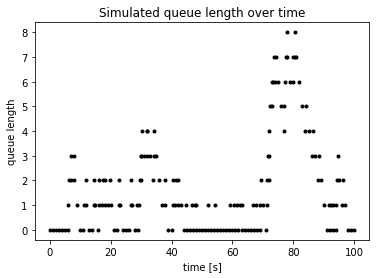

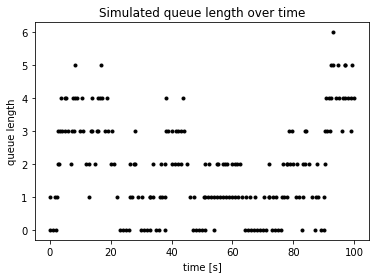

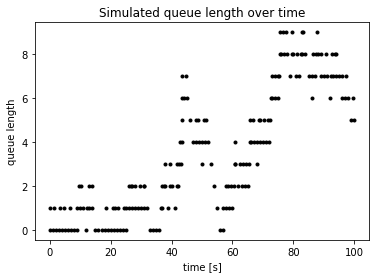

In [32]:
arrival_rate = 1
departure_rate = 1
final_time = 100

# Run the simulation 3 times to see different random results
for i in range(3):
    run_experiment(arrival_rate, departure_rate, final_time)
